In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import chromedriver_autoinstaller

import time
import random
import subprocess
from datetime import datetime
import missingno as ms
from plotnine import *
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

## Load Seasons with Raptor and Combine (2018-2022)

In [103]:
f2018 = pd.read_pickle('nba-2018-2019-with-raptor.pkl')
f2019 = pd.read_pickle('nba-2019-2020-with-raptor.pkl')
f2020 = pd.read_pickle('nba-2020-2021-with-raptor.pkl')
f2021 = pd.read_pickle('nba-2021-2022-with-raptor.pkl')

base_analysis = pd.concat([f2018,f2019,f2020,f2021]).reset_index()
base_analysis = base_analysis.drop_duplicates()

In [104]:
base_analysis.to_pickle('base_analysis.pkl')

In [105]:
df = pd.read_pickle('base_analysis.pkl')

In [106]:
# Includes all betmakers
df.shape

(107938, 15)

In [93]:
df.head()

,date,Home,Away,Home_Score,Away_Score,Bookmaker,Odds_Home,Odds_Away,Elo_Home,Elo_Away,Elo_Prob_Home,Elo_Prob_Away,Raptor_Home,Raptor_Away,Raptor_Prob_Home,Raptor_Prob_Away,team1,team2,season,Implied_Prob_Home,Implied_Prob_Away,Implied_Prob_Total,Actual_Winner,Implied_Pred_Winner,Implied_Correct_Call,Raptor_Pred_Winner,Raptor_Correct_Call,Elo_Pred_Winner,Elo_Correct_Call,Raptor_Implied_Difference_Home,Elo_Implied_Difference_Home,Raptor_Implied_Difference_Away,Elo_Implied_Difference_Away,Raptor_Implied_Difference_Bin_Home,Raptor_Prob_Bin_Home,Elo_Prob_Bin_Home,Implied_Prob_Bin_Home,Raptor_Implied_Difference_Bin_Away,Raptor_Prob_Bin_Away,Elo_Prob_Bin_Away,Implied_Prob_Bin_Away
0,2018-10-16,BOS,PHI,105.0,87.0,Unibet,-208,+170,1561.524193,1607.057688,0.577748,0.422252,1633.000000,1617.000000,0.653167,0.346833,BOS,PHI,2019,0.675325,0.370370,1.045695,Home,Home,True,Home,True,Home,True,-0.022158,-0.097577,-0.023537,0.051882,-0.02,0.66,0.58,0.68,-0.02,0.34,0.42,0.38
32,2018-10-16,GSW,OKC,108.0,100.0,Betsson,-1250,+744,1684.816393,1584.317968,0.760270,0.239730,1751.000000,1625.000000,0.786929,0.213071,GSW,OKC,2019,0.925926,0.118483,1.044409,Home,Home,True,Home,True,Home,True,-0.138997,-0.165656,0.094587,0.121246,-0.14,0.78,0.76,0.92,0.10,0.22,0.24,0.12
75,2018-10-17,CHO,MIL,112.0,113.0,William Hill,+140,-161,1501.955313,1517.813792,0.618776,0.381224,1474.284521,1555.449343,0.530984,0.469016,CHO,MIL,2019,0.416667,0.616858,1.033525,Away,Away,True,Home,False,Home,False,0.114317,0.202110,-0.147842,-0.235635,0.12,0.54,0.62,0.42,-0.14,0.46,0.38,0.62
57,2018-10-17,DET,BRK,103.0,100.0,Marathonbet,-244,+222,1492.025381,1432.381866,0.714835,0.285165,1488.718841,1454.660690,0.688781,0.311219,DET,BRK,2019,0.709302,0.310559,1.019861,Home,Home,True,Home,True,Home,True,-0.020522,0.005532,0.000660,-0.025394,-0.02,0.68,0.72,0.70,0.00,0.32,0.28,0.32
194,2018-10-17,HOU,NOP,112.0,131.0,1xBet,-357,+304,1654.095907,1565.012972,0.748090,0.251910,1662.495003,1554.859344,0.762027,0.237973,HOU,NOP,2019,0.781182,0.247525,1.028706,Away,Home,False,Home,False,Home,False,-0.019154,-0.033092,-0.009552,0.004386,-0.02,0.76,0.74,0.78,-0.00,0.24,0.26,0.24


In [57]:
def implied_odds_from_american(american_odds):
    try:
        american_odds = int(american_odds)
    except:
        return np.nan
    
    if abs(american_odds) < 100:
        raise ValueError(f"American odds must always have absolute value over 100. Supplied odds: {american_odds}")

    if american_odds < 0:
        return -american_odds / (-american_odds + 100)
    return 100 / (american_odds + 100)

def prediction_from_probabilities(home_prob, away_prob): 
    if home_prob > away_prob:
        return 'Home'
    elif away_prob > home_prob:
        return 'Away'
    return None

def actual_winner(row):
    home_score = int(row['Home_Score'])
    away_score = int(row['Away_Score'])
    
    if home_score > away_score:
        return 'Home'
    elif away_score > home_score:
        return 'Away'
    return None

def score_prediction(prediction, actual):
    return True if prediction == actual else False


In [58]:
df['Implied_Prob_Home'] = df['Odds_Home'].apply(implied_odds_from_american)
df['Implied_Prob_Away'] = df['Odds_Away'].apply(implied_odds_from_american)
df['Implied_Prob_Total'] = df['Implied_Prob_Home'] + df['Implied_Prob_Away']

In [59]:
df['Actual_Winner'] = df.apply(actual_winner, axis=1)

In [60]:
df['Implied_Pred_Winner'] = df.apply(lambda x: prediction_from_probabilities(x['Implied_Prob_Home'], x['Implied_Prob_Away']), axis=1)
df['Implied_Correct_Call'] = df.apply(lambda x: score_prediction(x['Implied_Pred_Winner'], x['Actual_Winner']), axis=1)

In [61]:
df['Raptor_Pred_Winner'] = df.apply(lambda x: prediction_from_probabilities(x['Raptor_Prob_Home'], x['Raptor_Prob_Away']), axis=1)
df['Raptor_Correct_Call'] = df.apply(lambda x: score_prediction(x['Raptor_Pred_Winner'], x['Actual_Winner']), axis=1)

In [62]:
df['Elo_Pred_Winner'] = df.apply(lambda x: prediction_from_probabilities(x['Elo_Prob_Home'], x['Elo_Prob_Away']), axis=1)
df['Elo_Correct_Call'] = df.apply(lambda x: score_prediction(x['Elo_Pred_Winner'], x['Actual_Winner']), axis=1)

In [63]:
df.head()

,date,Home,Away,Home_Score,Away_Score,Bookmaker,Odds_Home,Odds_Away,Elo_Home,Elo_Away,Elo_Prob_Home,Elo_Prob_Away,Raptor_Home,Raptor_Away,Raptor_Prob_Home,Raptor_Prob_Away,team1,team2,season,Implied_Prob_Home,Implied_Prob_Away,Implied_Prob_Total,Actual_Winner,Implied_Pred_Winner,Implied_Correct_Call,Raptor_Pred_Winner,Raptor_Correct_Call,Elo_Pred_Winner,Elo_Correct_Call,Raptor_Implied_Difference_Home,Elo_Implied_Difference_Home,Raptor_Implied_Difference_Away,Elo_Implied_Difference_Away,Raptor_Implied_Difference_Bin_Home,Raptor_Prob_Bin_Home,Elo_Prob_Bin_Home,Implied_Prob_Bin_Home,Raptor_Implied_Difference_Bin_Away,Raptor_Prob_Bin_Away,Elo_Prob_Bin_Away,Implied_Prob_Bin_Away
0,2018-10-16,BOS,PHI,105.0,87.0,Unibet,-208,+170,1561.524193,1607.057688,0.577748,0.422252,1633.0,1617.0,0.653167,0.346833,BOS,PHI,2019,0.675325,0.370370,1.045695,Home,Home,True,Home,True,Home,True,-0.022158,-0.097577,-0.023537,0.051882,-0.02,0.66,0.58,0.68,-0.02,0.34,0.42,0.38
1,2018-10-16,BOS,PHI,105.0,87.0,888sport,-208,+170,1561.524193,1607.057688,0.577748,0.422252,1633.0,1617.0,0.653167,0.346833,BOS,PHI,2019,0.675325,0.370370,1.045695,Home,Home,True,Home,True,Home,True,-0.022158,-0.097577,-0.023537,0.051882,-0.02,0.66,0.58,0.68,-0.02,0.34,0.42,0.38
2,2018-10-16,BOS,PHI,105.0,87.0,bwin,-208,+170,1561.524193,1607.057688,0.577748,0.422252,1633.0,1617.0,0.653167,0.346833,BOS,PHI,2019,0.675325,0.370370,1.045695,Home,Home,True,Home,True,Home,True,-0.022158,-0.097577,-0.023537,0.051882,-0.02,0.66,0.58,0.68,-0.02,0.34,0.42,0.38
3,2018-10-16,BOS,PHI,105.0,87.0,188BET,-213,+175,1561.524193,1607.057688,0.577748,0.422252,1633.0,1617.0,0.653167,0.346833,BOS,PHI,2019,0.680511,0.363636,1.044148,Home,Home,True,Home,True,Home,True,-0.027344,-0.102763,-0.016803,0.058616,-0.02,0.66,0.58,0.68,-0.02,0.34,0.42,0.36
4,2018-10-16,BOS,PHI,105.0,87.0,ComeOn,-222,+179,1561.524193,1607.057688,0.577748,0.422252,1633.0,1617.0,0.653167,0.346833,BOS,PHI,2019,0.689441,0.358423,1.047864,Home,Home,True,Home,True,Home,True,-0.036274,-0.111693,-0.011590,0.063829,-0.04,0.66,0.58,0.68,-0.02,0.34,0.42,0.36


In [64]:
for t in ['Home','Away']:
    df[f'Raptor_Implied_Difference_{t}'] = df[f'Raptor_Prob_{t}'] - df[f'Implied_Prob_{t}']
    df[f'Elo_Implied_Difference_{t}'] = df[f'Elo_Prob_{t}'] - df[f'Implied_Prob_{t}']

In [65]:
bin_ = 0.02

for t in ['Home','Away']:
    df[f'Raptor_Implied_Difference_Bin_{t}'] = round(df[f'Raptor_Implied_Difference_{t}'] / bin_) * bin_
    df[f'Raptor_Prob_Bin_{t}'] = round(df[f'Raptor_Prob_{t}'] / bin_) *bin_
    df[f'Elo_Prob_Bin_{t}'] = round(df[f'Elo_Prob_{t}'] / bin_) * bin_
    df[f'Implied_Prob_Bin_{t}'] = round(df[f'Implied_Prob_{t}'] / bin_) * bin_

### Sample one bookmaker er game

In [66]:
df1 = df.groupby(by=['date','Home','Away']).sample(n=1)

In [67]:
print("Total Games:",df1.shape[0])

Total Games: 4764


In [68]:
df1.sample(5)

,date,Home,Away,Home_Score,Away_Score,Bookmaker,Odds_Home,Odds_Away,Elo_Home,Elo_Away,Elo_Prob_Home,Elo_Prob_Away,Raptor_Home,Raptor_Away,Raptor_Prob_Home,Raptor_Prob_Away,team1,team2,season,Implied_Prob_Home,Implied_Prob_Away,Implied_Prob_Total,Actual_Winner,Implied_Pred_Winner,Implied_Correct_Call,Raptor_Pred_Winner,Raptor_Correct_Call,Elo_Pred_Winner,Elo_Correct_Call,Raptor_Implied_Difference_Home,Elo_Implied_Difference_Home,Raptor_Implied_Difference_Away,Elo_Implied_Difference_Away,Raptor_Implied_Difference_Bin_Home,Raptor_Prob_Bin_Home,Elo_Prob_Bin_Home,Implied_Prob_Bin_Home,Raptor_Implied_Difference_Bin_Away,Raptor_Prob_Bin_Away,Elo_Prob_Bin_Away,Implied_Prob_Bin_Away
33101,2019-12-02,CHO,PHO,104.0,109.0,Betfred,+140,-175,1428.708192,1394.148570,0.684512,0.315488,1333.345411,1538.524713,0.360406,0.639594,CHO,PHO,2020,0.416667,0.636364,1.053030,Away,Away,True,Away,True,Home,False,-0.056261,0.267846,0.003230,-0.320876,-0.06,0.36,0.68,0.42,0.00,0.64,0.32,0.64
53403,2021-01-24,BOS,CLE,141.0,103.0,bwin,-278,+220,1569.554749,1402.065353,0.823435,0.176565,1563.091908,1400.495880,0.793190,0.206810,BOS,CLE,2021,0.735450,0.312500,1.047950,Home,Home,True,Home,True,Home,True,0.057740,0.087985,-0.105690,-0.135935,0.06,0.80,0.82,0.74,-0.10,0.20,0.18,0.32
74174,2021-06-09,PHO,DEN,123.0,98.0,Betfred,-238,+188,1674.338274,1635.744867,0.689505,0.310495,1701.543333,1608.779479,0.728755,0.271245,PHO,DEN,2021,0.704142,0.347222,1.051364,Home,Home,True,Home,True,Home,True,0.024613,-0.014637,-0.075977,-0.036728,0.02,0.72,0.68,0.70,-0.08,0.28,0.32,0.34
105829,2022-04-17,MIL,CHI,93.0,86.0,BetVictor,-625,+500,1577.357836,1461.243681,0.776269,0.223731,1721.670518,1495.355795,0.865635,0.134365,MIL,CHI,2022,0.862069,0.166667,1.028736,Home,Home,True,Home,True,Home,True,0.003566,-0.085800,-0.032302,0.057065,0.00,0.86,0.78,0.86,-0.04,0.14,0.22,0.16
77769,2021-11-05,WAS,MEM,115.0,87.0,Betway,-145,+125,1512.049298,1536.879700,0.606521,0.393479,1520.144877,1537.767741,0.612660,0.387340,WAS,MEM,2022,0.591837,0.444444,1.036281,Home,Home,True,Home,True,Home,True,0.020824,0.014684,-0.057105,-0.050965,0.02,0.62,0.60,0.60,-0.06,0.38,0.40,0.44


In [69]:
df1.columns

Index(['date', 'Home', 'Away', 'Home_Score', 'Away_Score', 'Bookmaker',
       'Odds_Home', 'Odds_Away', 'Elo_Home', 'Elo_Away', 'Elo_Prob_Home',
       'Elo_Prob_Away', 'Raptor_Home', 'Raptor_Away', 'Raptor_Prob_Home',
       'Raptor_Prob_Away', 'team1', 'team2', 'season', 'Implied_Prob_Home',
       'Implied_Prob_Away', 'Implied_Prob_Total', 'Actual_Winner',
       'Implied_Pred_Winner', 'Implied_Correct_Call', 'Raptor_Pred_Winner',
       'Raptor_Correct_Call', 'Elo_Pred_Winner', 'Elo_Correct_Call',
       'Raptor_Implied_Difference_Home', 'Elo_Implied_Difference_Home',
       'Raptor_Implied_Difference_Away', 'Elo_Implied_Difference_Away',
       'Raptor_Implied_Difference_Bin_Home', 'Raptor_Prob_Bin_Home',
       'Elo_Prob_Bin_Home', 'Implied_Prob_Bin_Home',
       'Raptor_Implied_Difference_Bin_Away', 'Raptor_Prob_Bin_Away',
       'Elo_Prob_Bin_Away', 'Implied_Prob_Bin_Away'],
      dtype='object')

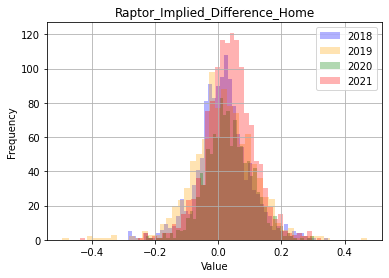

In [83]:
grouped = df1.groupby('season')

# Define colors and labels for the histogram groups
colors = ['blue', 'orange', 'green', 'red']
labels = ['2018', '2019', '2020', '2021']

# Iterate through groups and create histograms
for i, (name, group) in enumerate(grouped):
    plt.hist(group['Raptor_Implied_Difference_Home'], bins=50, alpha=0.3, color=colors[i], label=labels[i])

plt.title('Raptor_Implied_Difference_Home')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

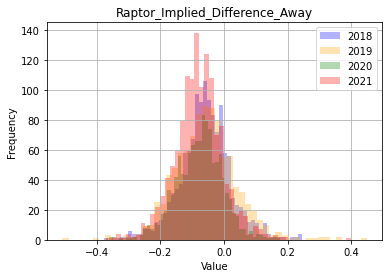

In [82]:
grouped = df1.groupby('season')

# Define colors and labels for the histogram groups
colors = ['blue', 'orange', 'green', 'red']
labels = ['2018', '2019', '2020', '2021']

# Iterate through groups and create histograms
for i, (name, group) in enumerate(grouped):
    plt.hist(group['Raptor_Implied_Difference_Away'], bins=50, alpha=0.3, color=colors[i], label=labels[i])

plt.title('Raptor_Implied_Difference_Away')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

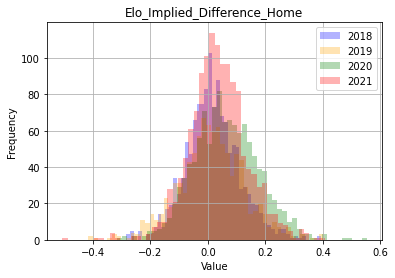

In [86]:
grouped = df1.groupby('season')

# Define colors and labels for the histogram groups
colors = ['blue', 'orange', 'green', 'red']
labels = ['2018', '2019', '2020', '2021']

# Iterate through groups and create histograms
for i, (name, group) in enumerate(grouped):
    plt.hist(group['Elo_Implied_Difference_Home'], bins=50, alpha=0.3, color=colors[i], label=labels[i])

plt.title('Elo_Implied_Difference_Home')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

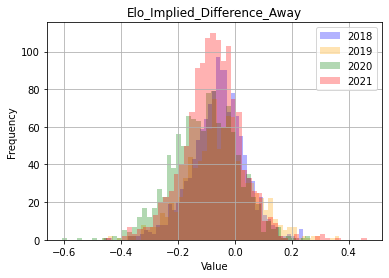

In [87]:
grouped = df1.groupby('season')

# Define colors and labels for the histogram groups
colors = ['blue', 'orange', 'green', 'red']
labels = ['2018', '2019', '2020', '2021']

# Iterate through groups and create histograms
for i, (name, group) in enumerate(grouped):
    plt.hist(group['Elo_Implied_Difference_Away'], bins=50, alpha=0.3, color=colors[i], label=labels[i])

plt.title('Elo_Implied_Difference_Away')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
cross_tab = pd.crosstab(df1[f'Raptor_Prob_Bin_Home'], df['Product'])


In [ ]:
def place_bet(row, team):
    if row[f'imp_raptor_diff_{team}'] < -0.2:
        return row[f'imp_raptor_diff_{team}']*-100
    else:
        return 0
    
def calculate_return(row, team):
    if row[f'bet_{team}'] == 0:
        return 0
    if row['Actual_Winner'] != f'{team}':
        return 0
    else:
        odds = int(row[f'{team}_Amer'])
        if odds < 0:
            return row[f'bet_{team}'] + ((100/abs(odds)) * row[f'bet_{team}'])
        if odds > 0:
            return row[f'bet_{team}'] + ((odds/100) * row[f'bet_{team}'])

In [ ]:
full['bet_Home'] = full.apply(place_bet, team='Home', axis=1)
# full['bet_Home'] = 0

full['bet_Away'] = full.apply(place_bet, team='Away', axis=1)
# full['bet_Away'] = 0


full['return_Home'] = full.apply(calculate_return, team='Home', axis=1)
# full['return_Home'] = 0

full['return_Away'] = full.apply(calculate_return, team='Away', axis=1)
# full['return_Away'] = 0

full['profit_Home'] = full['return_Home'] - full['bet_Home']
full['profit_Away'] = full['return_Away'] - full['bet_Away']
full['profit_Total'] = full['profit_Home'] + full['profit_Away']

In [ ]:
subset = full[[
    'date',
    'Home_AbbrB','Away_AbbrB','Bookmaker',
    'Home_Amer','Away_Amer',
    'Home_Imp','Away_Imp',
    'elo_prob1','elo_prob2',
    'raptor_prob1','raptor_prob2',
    'imp_elo_diff_Home','imp_elo_diff_Away',
    'imp_raptor_diff_Home','imp_raptor_diff_Away',
    'bet_Home','bet_Away',
    'return_Home','return_Away',
    'profit_Home','profit_Away']]

### Home Bets

In [ ]:
len(full[full['bet_Home'] > 0])

### Away Bets

In [ ]:
len(full[full['bet_Away'] > 0])

In [ ]:
total_bets = len(full[full['bet_Home'] > 0]) + len(full[full['bet_Away'] > 0])

print(f'Total Bets Made: {total_bets}')

total_bet_amount = sum(full['bet_Home']) + sum(full['bet_Away'])
print(f'Total Amount Bet: {"${:,.0f}".format(total_bet_amount)}')

In [ ]:
bets_won = (full['profit_Home'] > 0).sum() + (full['profit_Away'] > 0).sum()
bets_lost = (full['profit_Home'] < 0).sum() + (full['profit_Away'] < 0).sum()
print(f'Total Bets Won: {bets_won}')
print(f'Total Bets Lost: {bets_lost}')
print(f'Bet Win Percentage: {round(100*bets_won/(bets_won + bets_lost),2)}%')

In [ ]:
print(f'Total Amount Bet: {"${:,.0f}".format(total_bet_amount)}')

total_winnings = full['return_Home'].sum() + full['return_Away'].sum()
print(f'Total Winnings: {"${:,.0f}".format(total_winnings)}')

total_profit = full['profit_Home'].sum() + full['profit_Away'].sum()
print(f'Total Profit: {"${:,.0f}".format(total_profit)}')

total_roi = 100 * total_profit / total_bet_amount
print(f'Total ROI: {"{:.2f}%".format(total_roi)}')

In [ ]:
bets = full[(full['bet_Home'] > 0) | (full['bet_Away'] > 0)]

In [ ]:
bets = bets.sort_values(by=['date'])

In [ ]:
bets['cumulative_profit'] = bets['profit_Total'].cumsum()

In [ ]:
len(bets)

In [ ]:
bets.head()

In [ ]:
import matplotlib.dates as mdates

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Assuming your dataframe is named 'bets'
# ... (your previous code for adding total_profit and sorting the dataframe)

# Step 4: Plot the cumulative profit over time using matplotlib
plt.figure(figsize=(14, 4))
plt.plot(bets['date'], bets['cumulative_profit'], marker='o')

# Set the x-axis format
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(12))  # Set the maximum number of x-axis ticks to 6
plt.xticks(rotation=45)  # Rotate the ticks for better readability

plt.xlabel('Date')
plt.ylabel('Cumulative Profit')
plt.title('Cumulative Profit Over Time')
plt.grid()
plt.show()

In [ ]:
(ggplot(full, aes(x='raptor_prob1', y='elo_prob1'))
+ geom_point(alpha=0.1)
+ xlim(0,1)
+ ylim(0,1)
+ geom_abline(slope=1, intercept=0)
+ labs(title='Home: Raptor Probability vs. Elo Probability',
       x='Raptor Probability (Home Win)',
       y='Elo Probability (Home Win)')
+ theme_minimal())

In [ ]:
(ggplot(full, aes(x='raptor_prob1', y='Home_Imp'))
+ geom_point(alpha=0.1)
+ xlim(0,1)
+ ylim(0,1)
+ geom_abline(slope=1, intercept=0)
+ labs(title='Home: Raptor Probability vs. Bookmaker Implied Probability',
       x='Raptor Probability (Home Win)',
       y='Bookmaker Implied Probability (Home Win)')
+ theme_minimal())

In [ ]:
(ggplot(full, aes(x='elo_prob1', y='Home_Imp'))
+ geom_point(alpha=0.1)
+ xlim(0,1)
+ ylim(0,1)
+ geom_abline(slope=1, intercept=0)
+ labs(title='Home: Elo Probability vs. Bookmaker Implied Probability',
       x='Elo Probability (Home Win)',
       y='Bookmaker Implied Probability (Home Win)')
+ theme_minimal())

In [ ]:
(ggplot(full, aes(x='raptor_prob2', y='elo_prob2'))
+ geom_point(alpha=0.1)
+ xlim(0,1)
+ ylim(0,1)
+ geom_abline(slope=1, intercept=0)
+ labs(title='Away: Raptor Probability vs. Elo Probability',
       x='Raptor Probability (Away Win)',
       y='Elo Probability (Away Win)')
+ theme_minimal())

In [ ]:
(ggplot(full, aes(x='raptor_prob2', y='Away_Imp'))
+ geom_point(alpha=0.1)
+ xlim(0,1)
+ ylim(0,1)
+ geom_abline(slope=1, intercept=0)
+ labs(title='Away: Raptor Probability vs. Bookmaker Implied Probability',
       x='Raptor Probability (Away Win)',
       y='Bookmaker Implied Probability (Away Win)')
+ theme_minimal())

In [ ]:
(ggplot(full, aes(x='elo_prob2', y='Away_Imp'))
+ geom_point(alpha=0.1)
+ xlim(0,1)
+ ylim(0,1)
+ geom_abline(slope=1, intercept=0)
+ labs(title='Away: Elo Probability vs. Bookmaker Implied Probability',
       x='Elo Probability (Away Win)',
       y='Bookmaker Implied Probability (Away Win)')
+ theme_minimal())